# AAPL Demo: volatility fitting, and computing implied probability distributions

This notebook is a full walk-through of how to fit a volatility smile and use it to infer implied probability distributions (for a single expiry date), 
using AAPL CSV data.

Goals for this notebook:
1. Fit a VolCurve to one expiry, and use the fitted smile to price options and compute Greeks
2. Derive the implied probability (ProbCurve) and query tail probabilities and moments

---

## Goal 1: Fitting a volatility smile using the `VolCurve` object

We will:
1) Load input data
3) Fit a vol smile
4) Use the fitted smile to price options and compute greeks

In [1]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from oipd import VolCurve, MarketInputs, sources

### 1.1 Load input data

First, upload options chain data from a CSV

In [2]:
# map the raw data column names to the naming conventions accepted by OIPD
# raw column names : OIPD names
COLUMN_MAPPING = {
    "strike": "strike",
    "last_price": "last_price",
    "bid": "bid",
    "ask": "ask",
    "expiration": "expiry",
    "type": "option_type",
}

# `sources` is convenient method to ingest CSV or DataFrame files 
# Alternatively, you can use pandas.read_csv()
df_aapl = sources.from_csv("data/AAPL_data.csv", column_mapping=COLUMN_MAPPING)

# The date that we're interested in (select the expiry date of the option)
expiry = "2026-01-16"
df_expiry = df_aapl[df_aapl["expiry"] == expiry].copy()

<B>The `MarketInputs` object</B>

`MarketInputs` is a snapshot of market conditions (valuation date, underlying price, risk free rate) that the model uses to fit the volatility smile.


In [28]:
# define the market conditions
market = MarketInputs(
    valuation_date=date(2025, 10, 6), # date on which the options data was downloaded
    risk_free_rate=0.04,              # the risk-free rate of return. Use the US Fed or Treasury yields that are closest to the horizon of the expiry date (e.g. 3-month since we're evaluating on Oct 2025 for expiry on Jan 2026)
    underlying_price=256.69,          # the price of the underlying stock at the time when the options data was downloaded
)

### 1.2 Fitting the Volatility Smile

Now that all input data is loaded and defined, we can fit the vol smile. 

We first initialize a `VolCurve` object, which is a shell used to store the fitted vol smile. 

Once fitted, it can be queried using convenient methods, like `vol_curve.plot()`.

In [14]:
vol_curve = VolCurve() # initialize the VolCurve object
vol_curve.fit(df_expiry, market) # fit using the input data we defined, which populates the VolCurve object with results

/Users/henrytian/Coding Projects/Github/probabilistic/oipd/interface/volatility.py:169: UserWarning: Filled 16 missing mid prices with last_price due to unavailable bid/ask
  warnings.warn(


### 1.3 Use the fitted vol smile to price options, compute Greeks, etc.

First, let's visualize the fit. 

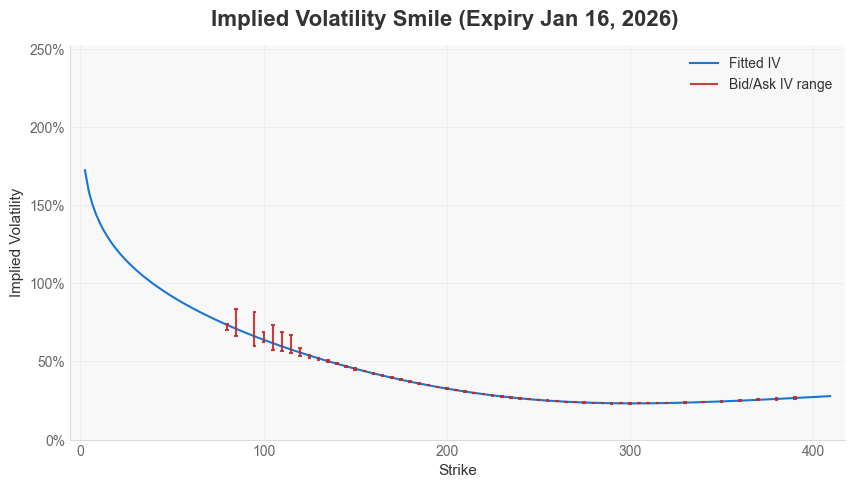

In [20]:
vol_curve.plot(include_observed=True)
plt.show()

Now that the vol smile has been fitted, we can evaluate the theoretical IV and total variance at a set of strikes. 

In [18]:
strikes = np.array([220.0, 240.0, 260.0, 280.0, 300.0])

print(vol_curve.implied_vol(strikes))
print(vol_curve.total_variance(strikes))

[0.29063876 0.26384154 0.24555346 0.23516995 0.23166051]
[0.02360556 0.01945332 0.01684998 0.01545507 0.01499724]


We can also find theoretical options prices and Greeks.

In [19]:
call_prices = vol_curve.price(strikes, call_or_put="call")
put_prices = vol_curve.price(strikes, call_or_put="put")

# Bulk Greeks
all_greeks = vol_curve.greeks(strikes, call_or_put="call")
all_greeks["call_price"] = call_prices
all_greeks["put_price"] = put_prices
all_greeks

,strike,delta,gamma,vega,theta,rho,call_price,put_price
0,220.0,0.865656,0.005094,27.867496,-16.159353,-11.651930,41.695632,2.609687
1,240.0,0.727644,0.008934,44.367059,-21.963753,-7.121981,25.485522,6.177259
2,260.0,0.514485,0.011695,54.054008,-24.270914,-3.649568,13.059730,13.529150
3,280.0,0.288380,0.010519,46.561053,-19.810939,-1.533185,5.486399,25.733503
4,300.0,0.129431,0.006613,28.835169,-12.030250,-0.547329,1.958579,41.983367


Lastly, we can download a DataFrame of fitted theoretical IV vs raw IV observed in market data (note that market IV only exists at a small set of strikes).

Also note that our data came from Yahoo Finance, whose raw IV is usually inaccurate (see https://chasethedevil.github.io/post/yahoo_finance_implied_volatility/)

In [25]:
vol_curve.iv_results().head(10)

,strike,fitted_iv,market_iv,market_bid_iv,market_ask_iv,market_last_iv
0,2.500000,1.722924,NaN,NaN,NaN,NaN
1,4.543970,1.591854,NaN,NaN,NaN,NaN
2,5.000000,1.569923,2.406683,NaN,2.406683,2.406683
3,6.587940,1.505016,NaN,NaN,NaN,NaN
4,8.631910,1.438813,NaN,NaN,NaN,NaN
5,10.000000,1.401574,1.950471,NaN,1.950471,1.950471
6,10.675879,1.384728,NaN,NaN,NaN,NaN
7,12.719849,1.338674,NaN,NaN,NaN,NaN
8,14.763819,1.298358,NaN,NaN,NaN,NaN
9,15.000000,1.293999,1.694440,NaN,1.694440,1.694440


---

## Goal 2: Build the `ProbCurve` to understand market-implied probabilities

The probability curve is the risk-neutral distribution implied by the fitted
smile. You can query tail probabilities, quantiles, and moments.

In [31]:
# use the vol_curve.implied_distribution() method 
prob_curve = vol_curve.implied_distribution() # --> returns a `ProbCurve` object. This is a container that holds information about market-implied probabilities. 

Now, we can query the result to quantify probabilities and other statistics.

In [32]:
spot = market.underlying_price
print(spot) # $256.69


prob_below = prob_curve.prob_below(240) # calculates Prob(price at expiry < 240)
prob_above = prob_curve.prob_above(280) # calculates Prob(price at expiry >= 280)
prob_between = prob_curve.prob_between(240, 280)

quantiles = {
    "q10": prob_curve.quantile(0.10),
    "q50": prob_curve.quantile(0.50),
    "q90": prob_curve.quantile(0.90),
}

moments = {
    "mean": prob_curve.mean(),
    "variance": prob_curve.variance(),
    "skew": prob_curve.skew(),
    "kurtosis": prob_curve.kurtosis(),
}

{
    "prob_below": prob_below,
    "prob_above": prob_above,
    "prob_between": prob_between,
    **quantiles,
    **moments,
}

256.69


{'prob_below': 0.26127259366619393,
 'prob_above': 0.26635702418076335,
 'prob_between': 0.4723703821530427,
 'q10': 217.18114699390688,
 'q50': 260.70391173316534,
 'q90': 301.73278119285004,
 'mean': 259.1660539591428,
 'variance': 1166.1686958870125,
 'skew': 0.021073653630052046,
 'kurtosis': 0.8290420598272563}

Plot the probability distributions

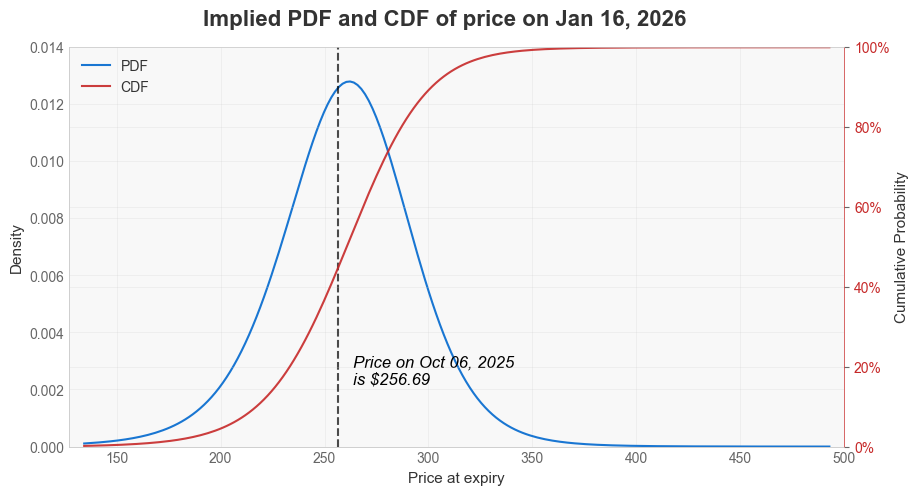

In [10]:
prob_curve.plot(kind="both")
plt.show()